In [6]:
include("/Users/gr_1/Documents/lemur/julia/run_lemur.jl")
include("/Users/gr_1/Documents/isoflex/IsoFlex.jl")
using Plots
lemur_params = lemur_obj();
using JLD

In [2]:
function dt(t)
    r_ = 100
    a = 1e-5
    m = 500
    n = 500
    U=zeros(m,n)
    for i = 1:m
        for j=1:n
            r = sqrt((Float64(i-m/2.00)^2+Float64(j-n/2.00)^2))
            U[i,j] = a * exp(-r^2/r_^2)

        end
    end
    return U
end

dt (generic function with 1 method)

In [130]:
function Isovary(t)
    dT = 50e6 #1/2 cycle duration
    tu = floor(t/dT)
    dt = 1e6
    if mod(tu,2) == 1
       c1 = 1-(t-dT*tu)/dT
       c2 = 1-(t+dt-dT*tu)/dT
    else
       c1 = (t-dT*tu)/dT
       c2 = (t+dt-dT*tu)/dT
    end
    
   W = zeros(500,500)

    maxsed = 2500 #Maximum sediment thickness at rho = 2750 kg/m3

   for i =100:230
        W[i, 150:350] .= - (i - 100) / 130 .* maxsed*2/3; #Minima is about half the maximum
    end
    for i =230:260
        W[i, 150:350] .= (i-230 ) / 30 .* (maxsed*1.67) - maxsed*2/3;
    end

    for i =260:340
        W[i, 150:350] .= (260 - i ) / 80 .* (maxsed*1.67)+maxsed;
    end
    for i =340:380
        W[i, 150:350] .= (i-340) / 40 .* maxsed * 2/3 - maxsed*2/3;
    end
   # W = reverse(W, dims = 1)


    U1 = IsoFlex.flexural(W, Nx = 0, Ny = -1e12*c1, dx=1000, dy=1000, Te = 10e3 - 1e3 * c1, ncores=1);
    U2 = IsoFlex.flexural(W, Nx = 0, Ny = -1e12*c2, dx=1000, dy=1000, Te = 10e3 - 1e3 * c2, ncores=1);

    return -(U2-U1)/dt
end

Isovary (generic function with 1 method)

In [133]:
function Isovary_total(t)
    dT = 50e6 #1/2 cycle duration
    tu = floor(t/dT)
    dt = 1e6
    if mod(tu,2) == 1
       c1 = 1-(t-dT*tu)/dT 
       c2 = 1-(t+dt-dT*tu)/dT 
    else
       c1 = (t-dT*tu)/dT 
       c2 = (t+dt-dT*tu)/dT
    end
    ny = 500
    nx = 500
    dx = 1000
    dy = 1000
    W = zeros(500,500)

    maxsed = 2500 #Maximum sediment thickness at rho = 2750 kg/m3



   for i =100:230
        W[i, 150:350] .= - (i - 100) / 130 .* maxsed*2/3; #Minima is about half the maximum
    end
    for i =230:260
        W[i, 150:350] .= (i-230 ) / 30 .* (maxsed*1.67) - maxsed*2/3;
    end

    for i =260:340
        W[i, 150:350] .= (260 - i ) / 80 .* (maxsed*1.67)+maxsed;
    end
    for i =340:380
        W[i, 150:350] .= (i-340) / 40 .* maxsed * 2/3 - maxsed*2/3;
    end
    #W = reverse(-W, dims = 1)

    U1 = IsoFlex.flexural(W, Nx = 0, Ny = -1e12*c1, dx=1000, dy=1000, Te = 10e3 - c1*1.0e3, ncores=1);
    return -U1
end

Isovary_total (generic function with 1 method)

In [134]:
pyplot()
for i =1:25e6:60e6
    I = Isovary(i)
    #heatmap(I) 
    #clims([-900,900])
end

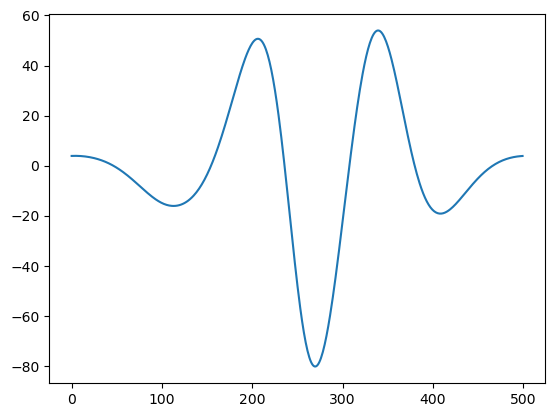

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbeaf1d1a00>

In [135]:
pyplot()
PyPlot.plot(Isovary_total(30e6)[:,250] - Isovary_total(0e6)[:,250])

In [108]:
# Grav

G = zeros(100,100)
d = 10000
dx = 5000.
G[40:60,20:80] .= -1e6*dx^2
G[40:50,20:80] .= 1e6*dx^2
z = 10000.
g=zeros(100, 100)
Threads.@threads for i1 = 1:100
    for j1 = 1:100
        for i = 1:100
             for j = 1:100
                r2 = ((i1 + .3 - float(i)) * dx) .^ 2 + ((j1 + .3 - float(j)) * dx) .^ 2. #.3 is avg distance to center from any point of square
                #deg = z / (sqrt(r2 + z^2))
                g[i1,j1] += (z + d/2) / (r2 + z^2+(d/2)^2) .^ 1.500 * G[i,j] * 7e-11 
            end
        end
    end
    print(i1)
end

1

TaskFailedException: [91mTaskFailedException:[39m
[91m[91mInterruptException:[39m[39m
[91mStacktrace:[39m
[91m [1] [1mmacro expansion[22m at [1m./In[108]:16[22m [inlined][39m
[91m [2] [1m(::var"#440#threadsfor_fun#11"{UnitRange{Int64}})[22m[1m([22m::Bool[1m)[22m at [1m./threadingconstructs.jl:61[22m[39m
[91m [3] [1m(::var"#440#threadsfor_fun#11"{UnitRange{Int64}})[22m[1m([22m[1m)[22m at [1m./threadingconstructs.jl:28[22m[39m

In [12]:
#Zi2 = data_100[1].z[:,:,1]
Zi = load("Zi.jld", "Zi");

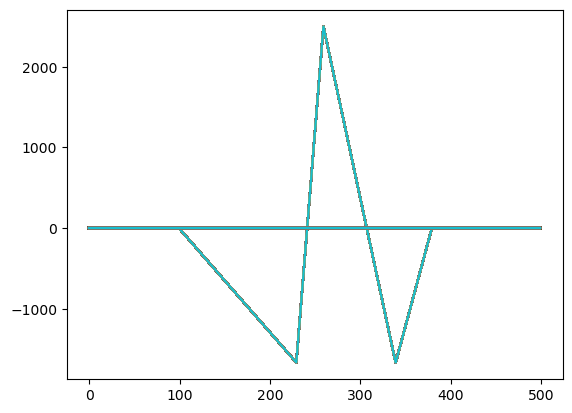

500-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc1b85db100>
 PyObject <matplotlib.lines.Line2D object at 0x7fc1b85db130>
 PyObject <matplotlib.lines.Line2D object at 0x7fc1b85db250>
 PyObject <matplotlib.lines.Line2D object at 0x7fc1b85db370>
 PyObject <matplotlib.lines.Line2D object at 0x7fc1b85db490>
 PyObject <matplotlib.lines.Line2D object at 0x7fc1b85db5b0>
 PyObject <matplotlib.lines.Line2D object at 0x7fc1b85db6d0>
 PyObject <matplotlib.lines.Line2D object at 0x7fc1b85db7f0>
 PyObject <matplotlib.lines.Line2D object at 0x7fc1b85db910>
 PyObject <matplotlib.lines.Line2D object at 0x7fc1b85dba30>
 PyObject <matplotlib.lines.Line2D object at 0x7fc1d8590af0>
 PyObject <matplotlib.lines.Line2D object at 0x7fc1b85dbb50>
 PyObject <matplotlib.lines.Line2D object at 0x7fc1b85dbd60>
 ⋮                                                          
 PyObject <matplotlib.lines.Line2D object at 0x7fc18a66ed00>
 PyObject <matplotlib.lines.Line2D object at 0x

In [10]:
gr()
   W = zeros(500,500)

    maxsed = 2500 #Maximum sediment thickness at rho = 2750 kg/m3

    for i =100:230
        W[i, 150:350] .= - (i - 100) / 130 .* maxsed*2/3; #Minima is about half the maximum
    end
    for i =230:260
        W[i, 150:350] .= (i-230 ) / 30 .* (maxsed*1.67) - maxsed*2/3;
    end

    for i =260:340
        W[i, 150:350] .= (260 - i ) / 80 .* (maxsed*1.67)+maxsed;
    end
    for i =340:380
        W[i, 150:350] .= (i-340) / 40 .* maxsed * 2/3 - maxsed*2/3;
    end


PyPlot.plot(W)

In [78]:
include("/Users/gr_1/Documents/lemur/julia/run_lemur.jl")
lemur_params = lemur_obj()
lemur_params.t_c = 0e6
lemur_params.dt = 1e6
lemur_params.flex = 30e3
lemur_params.kd=.00
lemur_params.l = 0.333 #really need to be float - check
lemur_params.undercapacity = ones(500,500)
lemur_params.m = .5
lemur_params.n = 1.0
lemur_params.z = Zi#rand(500, 500)
#lemur_params.z = lemur_params.z+rand(500,500)
lemur_params.t = 30e6
#lemur_params.z = Zi#copy(data_100[1].z[:,:,1])
#lemur_params.k[1:250,:] .= 8e-7
lemur_params.k[:,:] .= .2e-6
bcx = zeros(500,500)
bcx[:,1] .= 0
lemur_params.ks = .5e-6
bcx[end,:] .= 1
bcx[1,:] .= 1
bcx[:,end] .= 0
lemur_params.bcx = bcx
lemur_params.bc = findall(vec(bcx .== 1))
#lemur_params.ufunc = Isovary
lemur_params.u = zeros(500,500).+.000002
lemur_params.uselandsed = 2
lemur_params.maxareasinkfill = .000
lemur_params.precip = 0.25
lemur_params.evaprate = 2.0
data_100 = run_lemur.run(lemur_params,compute_sedflux=true);

k k
undercapacity undercapacity
z z
dx 1000.0
dx
dy 1000.0
dy
t 3.0e7
t
dt 1.0e6
dt
display 1.0
display
Udt 2.34728186e-314
Udt
flex 30000.0
flex
kd 0.0
kd
m 0.5
m
n 1.0
n
bc bc
wdt 2.34728186e-314
wdt
firstcall 1.0
firstcall
u u
udt 100000.0
udt
ny 500.0
ny
nx 500.0
nx
deposit 0.0
deposit
srho 2400.0
srho
drawdt 2.3472909508e-314
drawdt
l 1.0
l
ks 5.0e-7
ks
t_c 0.0
t_c
sinkfill 1.0
sinkfill
uselandsed 2.0
uselandsed
maxareasinkfill 0.0
maxareasinkfill
precip 0.25
precip
evaprate 2.0
evaprate
bcx bcx
k_sed k_sed


199.10900742027005
  0.540283 seconds (2.55 k allocations: 166.528 MiB, 18.63% gc time)
199.15086133150717
  0.494127 seconds (2.03 k allocations: 166.491 MiB, 18.73% gc time)
199.19313253660002
  0.443894 seconds (2.03 k allocations: 166.492 MiB, 0.63% gc time)


InterruptException: [91mInterruptException:[39m

In [50]:
save("./Zi3.jld", "Zi", Zi);
maximum(Zi)

199.06760604769426

In [40]:
Zi = data_100[1].z[:,:,end];

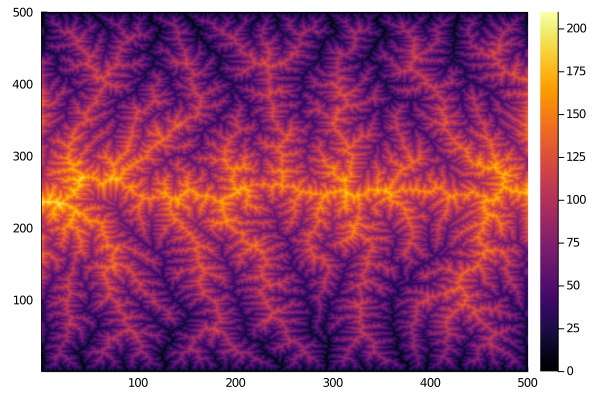

In [136]:
gr()
heatmap(Zi,clim=(0,210))

In [146]:
include("/Users/gr_1/Documents/lemur/julia/run_lemur.jl")
lemur_params = lemur_obj()
lemur_params.t_c = 0e6
lemur_params.dt = 1e6
lemur_params.flex = 10e3
lemur_params.kd=.01
lemur_params.l = 1.0 #really need to be float - check
lemur_params.undercapacity = ones(500,500)
lemur_params.m = .5
lemur_params.n = 1.0
#lemur_params.z = lemur_params.z+rand(500,500)
lemur_params.t = 500e6
lemur_params.z = Zi*1.0#copy(data_100[1].z[:,:,1])
#lemur_params.k[1:250,:] .= 8e-7
lemur_params.k[:,:] .= .2e-6 
bcx = zeros(500,500)
bcx[:,1] .= 0
lemur_params.ks = 1e-6
bcx[end,:] .= 1
bcx[1,:] .= 1
bcx[:,end] .= 0
lemur_params.bcx = bcx
lemur_params.bc = findall(vec(bcx) .== 1)
lemur_params.ufunc = Isovary
lemur_params.u = zeros(500,500).+.000002
lemur_params.uselandsed = 2
lemur_params.maxareasinkfill = 0
lemur_params.precip = .25
lemur_params.evaprate = 4.0
data_100 = run_lemur.run(lemur_params,compute_sedflux=true);

k k
undercapacity undercapacity
z z
dx 1000.0
dx
dy 1000.0
dy
t 5.0e8
t
dt 1.0e6
dt
display 1.0
display
Udt 2.34728186e-314
Udt
flex 10000.0
flex
kd 0.01
kd
m 0.5
m
n 1.0
n
bc bc
wdt 2.34728186e-314
wdt
firstcall 1.0
firstcall
u u
udt 100000.0
udt
ny 500.0
ny
nx 500.0
nx
deposit 0.0
deposit
srho 2400.0
srho
drawdt 2.3472909508e-314
drawdt
l 1.0
l
ks 1.0e-6
ks
t_c 0.0
t_c
sinkfill 1.0
sinkfill
uselandsed 2.0
uselandsed
maxareasinkfill 0.0
maxareasinkfill
precip 0.25
precip
evaprate 4.0
evaprate
bcx bcx
k_sed k_sed
198

.88585154936047
  0.574815 seconds (2.79 k allocations: 368.715 MiB, 29.87% gc time)
198.74059193782247
  0.498481 seconds (2.65 k allocations: 368.704 MiB, 17.81% gc time)
198.62769989121875
  0.412230 seconds (2.65 k allocations: 368.704 MiB, 1.36% gc time)
198.54374666055668
  0.431346 seconds (2.65 k allocations: 368.704 MiB, 1.35% gc time)
198.48579421884955
  0.417034 seconds (2.65 k allocations: 368.704 MiB, 1.36% gc time)
198.4512958669195
  0.478734 seconds (2.65 k allocations: 368.704 MiB, 18.61% gc time)
198.43801292854434
  0.417912 seconds (2.65 k allocations: 368.704 MiB, 1.33% gc time)
198.44394301872964
  0.428798 seconds (2.65 k allocations: 368.704 MiB, 1.30% gc time)
198.46726649744582
  0.418919 seconds (2.65 k allocations: 368.704 MiB, 1.35% gc time)
198.50631178342525
  0.477660 seconds (2.65 k allocations: 368.704 MiB, 18.52% gc time)
198.5595357011653
  0.407300 seconds (2.65 k allocations: 368.704 MiB, 1.39% gc time)
198.62551390110218
  0.418929 seconds (2.65 

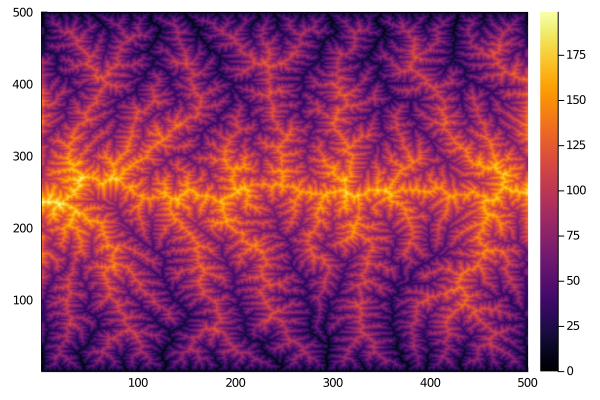

In [147]:
heatmap(Zi)

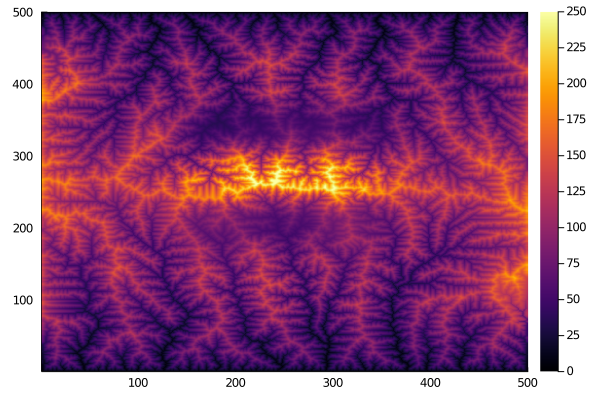

In [151]:
gr()
heatmap(data_100[1].z[:,:,Int(50)*10],clim=(0,250))

In [9]:
E = copy(data_100[1].ero[:,:,200])
n = length(vec(E).>0)
E[E.>0] .= 0
minimum(E)

-4.023566289865215

#### data_100

In [26]:
# anim = @animate for i = 1:5:length(data_100[3])
#     plot(data_100[1].z[:,:,i][Array{Int32}(data_100[3][i])], ylims=(-50,50))
# end 
# gif(anim, "/users/gr_1/Downloads/anim_fps15.gif", fps = 15)

v = PyPlot.cm.get_cmap("jet", 256)
ncolor = v(1:256)
ncolor[1,:] .= (0,0,0,1)
newc =  PyPlot.colors.(ncolor)## Vertical load and in plane stress variations - what values, what timescales?
### Right now using Arbritrary - ~70 m of uplift over 30 Ma
## Evidence of capture in fink?
## Low precip and ero - basin doesn't stay isolated very long
## Finke profile modeling
## timing from finke
## missionary plains sediment - compare
## 1 cycle - how disequilibrated, where are we in the current cycle?

In [ ]:
v = PyPlot.cm.get_cmap("jet", 256)
ncolor = v(1:256)
ncolor[1,:] .= Array{Float64}([0,0,0,1])
v._lut = ncolor

In [114]:
using Plots
using PyPlot

c=0
a1=0
for ti =1:5:500
    fig,ax= subplots(2,2,figsize=(20,10))
    tight_layout()
    ch = copy(data_100[1].chi[:,:,ti])
    s = copy(data_100[1].csed[:,:,ti])
    w= copy(data_100[1].cw[:,:,ti])
    
    idx = Array{Int32}(data_100[3][ti])
    profile = data_100[1].z[:,:,ti][idx]
    profile_sed = s[idx]

    a = copy(data_100[1].a[:,:,ti])
    ch[a .< 10] .= NaN
    ch[isnan.(ch)] .= 0

    iso = Isovary_total(ti*1e6) - Isovary_total(1*1e6)
    
    iso = reverse(iso,dims=1)
    a = reverse(a,dims=1)
    a1=a
    println(size(a))
    w = reverse(w,dims=1)
    s = reverse(s, dims=1)
    #ch = reverse(ch,dims=1)
    z = data_100[1].z[:,:,ti]
    z = reverse(z,dims=1)
    
    sca(ax[1])
    imshow(z,cmap= "terrain")
    clim([0,250])
    title("Elevation (m)")
    PyPlot.plot(Array{Float64}(floor.((idx) ./ 500)) .+ 1, 500 .- Array{Float64}(idx .% 500 .+ 1),color="r")
    colorbar()

    sca(ax[2])
    imshow(iso, cmap="bwr")
    clim([-120,120])
    title("Cumulative Uplift (m)")
    PyPlot.text(2.5,-120.5,string("Time = ",string(ti)," Myr"),fontsize="18")

    colorbar()

#     sca(ax[3])
#     pcolor(ch)
#     clim([.0, .45])
#     title("chi (m)")
#     xlabel("Distance (km)")
#     colorbar()

    sca(ax[3])
    imshow(s, cmap= "bwr"),
    clim([.0, 200])
    title("sed thickness (m)")
    colorbar()

#     sca(ax[5])
#     imshow(w,cmap="jet")
#     clim([.0, 2.5])
#     title("Lakes (m)")
#     println("here")
#     colorbar()
    #
    sca(ax[4])
    PyPlot.plot(1:length(profile), profile-profile_sed)
    PyPlot.plot(1:length(profile), profile,"r")

    ylim([-5, 250])
    xlabel("Distance (km)")
    ylabel("Elevation (m)")
    if c>99
        pad = ""
    elseif c > 9
        pad = "0"
    else
        pad = "00"
    end
    PyPlot.savefig(string("/users/gr_1/Documents/giftemp/gif",pad,string(c),".png"),dpi=50)
    c+=1
    close()
end


(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)
(500, 500)

In [264]:
magick convert /Users/gr_1/Documents/giftemp/*.png /Users/gr_1/Documents/giftemp/all.gif

LoadError: [91msyntax: extra token "convert" after end of expression[39m

In [61]:
function html_video(filename)
    open(filename) do f
        base64_video = base64encode(f)
        """<video controls src="data:video/x-m4v;base64,$base64_video">"""
    end
end

html_video (generic function with 1 method)

In [ ]:
display("text/html", html_video("test1.mp4"))

In [91]:
function downprof(Z,R,i,j,t)
    z = zeros(0)
    d = zeros(0)
        ij = i + (j-1) * m
        c=1
        while(R[i,j,t] != ij)
            ij =R[i,j,t]
            i2 = Int16((ij-1)%m +1)
            j2 = Int16(floor((ij-1)/m)+1)
            append!(d,((i-i2).^2 .+ (j-j2).^2).^.5)
            append!(z, (Z[i2, j2, t+1] - Z[i2,j2,t] - Isovary(t+1)[i2,j2]*1e6))
            i=i2
            j=j2
            c+=1
        end
    return(d,z)
end

downprof (generic function with 2 methods)

In [ ]:
dd = 5
m,n,ti = size(data_100[1].R)
anim = @animate for d = 1:dd:500
    d,z = downprof(data_100[1].z,data_100[1].R,350,250,d)
    plot(cumsum(d),z)
    ylims!((-2,2))
    xlims!((0,100))
end
gif(anim, "anim_fps152.gif", fps = 7)


In [ ]:
using Plots
pyplot()
a = zeros(length(data_100[1].u2[1,1,:]))
for i = 1:length(data_100[1].u2[1,1,:])
    a1  = 
    a[i] = sum(data_100[1].u2[3,:,i] /1e3 *2)
end
plot(0:.5:200,a,ylims=(0,3e4),legend=false,linewidth=3,xlabel = "Model run time (Myr)",ylabel="Sediment flux to southern margin ( km3 / Myr )" )
plot!(65:.1:65.1,0:3e4:3e4)

In [ ]:
plot(log.(a1[a1.>0]))

In [70]:
using Statistics
maximum(vec(data_100[1].u2[:,:,100]))

189.3223709094582

In [41]:
using Plots
a = zeros(length(data_100[1].u2[1,1,:]))
a1 = zeros(500)
for i = 1:length(data_100[1].u2[1,1,:])
    a1[:] .= data_100[1].u2[3,:,i]

    a[i] = sum(data_100[1].u2[3,:,i])
end
plot(0:.5:200,a,ylims=(0,1e7),legend=false,linewidth=3)

UndefVarError: [91mUndefVarError: plot not defined[39m

In [ ]:
lemur_params = lemur_obj()
lemur_params.t_c = 1e6
lemur_params.dt = .5e6
lemur_params.t = 200e6
lemur_params.flex = 40e3
lemur_params.k[:,:] .= 5e-7
lemur_params.z[1:250,:] .-= 2000
data_5 = run_lemur.run(lemur_params)

In [ ]:
lemur_params.t_c = 300e6
lemur_params.dt = .5e6
lemur_params.t = 50e6
lemur_params.flex = 40e3
lemur_params.k[:,:] .= 5e-7
lemur_params.z[1:250,:] .-= 2000
data_50_demo = run_lemur.run(lemur_params)

In [ ]:
data = data_100
@gif for t = 2:30:size(data[1].z)[3]
plt = plot(
    heatmap(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false)  ,
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500),title="Elevation (m)"),
    heatmap(data[1].chi[:,:,t],
    xaxis = ("Distance (km)"),yaxis = ("Distance (km)"), clim=(.5,1),title="Swath Elevation (m)"  ), layout=grid(1, 2),
    size=(1000,1500))
   
annotate!(200, 480, text("Time = " * string(t/2) * " Myr", :black, :left, 20),)
end



In [42]:
using Plots
using Statistics
gr()
#font = Plots.font("Helvetica", 18, weight= "light")
#pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
data = data_100
@gif for t = 2:30:size(data[1].z)[3]
plt = plot(
    heatmap(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false)  ,
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500),title="Elevation (m)"),
    heatmap(data[1].u[:,:,t]*2,c= cgrad(:RdBu_10,[.1], rev = true)  ,
    xaxis = ("Distance (km)"),clim=(-3,30),title="Uplift rate (m/Myr)",yaxis = false),
    heatmap(mean(data[1].chi[:,:,t],dims=2),linewidth=2,
    xaxis = ("Distance (km)"),yaxis = false, ylim=(0,2500),title="Swath Elevation (m)"  ), layout=grid(1, 3),
    size=(2000,1500))
   
annotate!(200, 480, text("Time = " * string(t/2) * " Myr", :black, :left, 20),)
end



InterruptException: [91mInterruptException:[39m

In [75]:
anim()

31

In [ ]:
using Plots
gr()
#font = Plots.font("Helvetica", 18, weight= "light")
#pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
data = data_5

@gif for t = 2:5:401
plt = plot(
    heatmap(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false)  ,
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500),title="Elevation (m)"),
    heatmap(data[1].u[:,:,t]*2,c= cgrad(:RdBu_10,[.1], rev = true)  ,
    xaxis = ("Distance (km)"),clim=(-3,30),title="Uplift rate (m/Myr)",yaxis = false),
    heatmap(data[1].z[:,:,t-1]*2 - data[1].z[:,:,t]*2+data[1].u[:,:,t] .* 2,c= cgrad(:RdBu_10,[.1], rev = true)  ,
    xaxis = ("Distance (km)"),yaxis = false, clim=(-6,60),title="Erosion rate (m/Myr)"),
    plot(mean(data[1].z[:,:,t],dims=2),linewidth=2,
    xaxis = ("Distance (km)"),yaxis = false, ylim=(0,2500),title="Swath Elevation (m)"  ),layout=grid(2, 2),
    size=(2000,1500))
annotate!(200, 480, text("Time = " * string(t/2) * " Myr", :black, :left, 12))
end 

In [ ]:
using Plots
gr()
#font = Plots.font("Helvetica", 18, weight= "light")
#pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
data = data_Inf

@gif for t = 2:5:401
plt = plot(
    plot(mean(data[1].z[:,:,t],dims=2),linewidth=2,
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),title="Elevation (m)",zlim=(0,2500)),
    plot(mean(data[1].z[:,:,t-1]-data[1].z[:,:,t]+data[1].u[:,:,t],dims=2),linewidth=2,
    xaxis = ("Distance (km)"),yaxis = false, ylim=(0,100),title="Erosion rate (m/Myr)"),layout=(1, 2))
    
annotate!(200, 10, text("Time = " * string(t/2) * " Myr", :black, :left, 12))
end 

In [ ]:
using Plots
gr()
#font = Plots.font("Helvetica", 18, weight= "light")
#pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
data = data_100

@gif for t = 2:5:401
plt = plot(
    plot(mean(data[1].z[:,:,t],dims=2)*2,linewidth=2,
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),title="Elevation (m)",ylim=(0,2500)),
    plot(mean(data[1].u[:,:,t],dims=2)*2,linewidth=2,
    xaxis = ("Distance (km)"),yaxis = false, ylim=(-5,15),title="Uplift rate (m/Myr)"),layout=(1, 2))
    
annotate!(200, 10, text("Time = " * string(t/2) * " Myr", :black, :left, 12))
end 

In [ ]:
using Plots
gr()
#font = Plots.font("Helvetica", 18, weight= "light")
#pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
data = data_50_demo

@gif for t = 2:5:101
plt = plot(
    plot(mean(data[1].z[:,:,t],dims=2)*2,linewidth=2,
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),title="Elevation (m)",ylim=(0,2500)),
    plot(mean(data[1].u[:,:,t],dims=2)*2,linewidth=2,
    xaxis = ("Distance (km)"),yaxis = false, ylim=(-5,15),title="Uplift rate (m/Myr)"),layout=(1, 2))
    
annotate!(200, 10, text("Time = " * string(t/2) * " Myr", :black, :left, 12))
end 

In [ ]:
using Plots
gr()
#font = Plots.font("Helvetica", 18, weight= "light")
#pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
data = data_Inf_demo

@gif for t = 2:5:101
plt = plot(
    plot(mean(data[1].z[:,:,t],dims=2)*2,linewidth=2,
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),title="Elevation (m)",ylim=(0,5000)),
    plot(mean(data[1].u[:,:,t],dims=2)*2,linewidth=2,
    xaxis = ("Distance (km)"),yaxis = false, ylim=(-5,15),title="Uplift rate (m/Myr)"),layout=(1, 2))
    
annotate!(200, 10, text("Time = " * string(t/2) * " Myr", :black, :left, 12))
end 

In [ ]:
using Plots
pyplot()
#font = Plots.font("Helvetica", 18, weight= "light")
pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
@gif for t = 1:5:401
data = data_Inf
plt = plot(
    heatmap(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false),size=(1500,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500),title="Elevation (m)"),
    heatmap(data[1].u[:,:,t]*2,c= cgrad(:RdBu_10,[.1], rev = true),size=(1500,500),
    xaxis = ("Distance (km)"),clim=(-3,30),title="Uplift rate (m/Myr)",yaxis = false),
    heatmap(data[1].z[:,:,t-1]*2 - data[1].z[:,:,t]*2+(data[1].u[:,:,t]*2),c= cgrad(:RdBu_10,[.1], rev = true),size=(1600,500),
    xaxis = ("Distance (km)"),yaxis = false, clim=(-60,600),title="Erosion rate (m/Myr)"),layout=(1,3))
annotate!(200, 480, text("Time = " * string(t/2) * " Myr", :black, :left, 12))
end 

In [ ]:
lemur_params.t_c = 100000000000000000000e6
data_Inf = run_lemur.run(lemur_params)

In [ ]:
using Plots
gr()
#font = Plots.font("Helvetica", 18, weight= "light")
#pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
data = data_Inf_demo

@gif for t = 2:5:101
plt = plot(
    plot(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false),size=(1500,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500),title="Elevation (m)"),
    heatmap(data[1].u[:,:,t]*2,c= cgrad(:RdBu_10,[.1], rev = true),size=(1500,1500),
    xaxis = ("Distance (km)"),clim=(-3,30),title="Uplift rate (m/Myr)",yaxis = false),
    heatmap(data[1].z[:,:,t-1]*2 - data[1].z[:,:,t]*2+data[1].u[:,:,t] .* 2,c= cgrad(:RdBu_10,[.1], rev = true),size=(1500,500),
    xaxis = ("Distance (km)"),yaxis = false, clim=(-6,60),title="Erosion rate (m/Myr)"),layout=(1, 3))
    
annotate!(200, 480, text("Time = " * string(t/2) * " Myr", :black, :left, 12))
end 

In [ ]:
using Plots
gr()
#font = Plots.font("Helvetica", 18, weight= "light")
#pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
data = data_50_demo

@gif for t = 2:5:101
plt = plot(
    heatmap(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false),size=(1500,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500),title="Elevation (m)"),
    heatmap(data[1].u[:,:,t]*2,c= cgrad(:RdBu_10,[.1], rev = true),size=(1500,1500),
    xaxis = ("Distance (km)"),clim=(-3,30),title="Uplift rate (m/Myr)",yaxis = false),
    heatmap(data[1].z[:,:,t-1]*2 - data[1].z[:,:,t]*2+data[1].u[:,:,t] .* 2,c= cgrad(:RdBu_10,[.1], rev = true),size=(1500,500),
    xaxis = ("Distance (km)"),yaxis = false, clim=(-6,60),title="Erosion rate (m/Myr)"),layout=(1, 3))
    
annotate!(200, 480, text("Time = " * string(t/2) * " Myr", :black, :left, 12))
end 

In [ ]:
#ont = Plots.font("Helvetica", 18, weight= "light")
pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
t = 401
data = data_100
plt = plot( 
    heatmap(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false),size=(1300,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500)),
    heatmap(data[1].u[:,:,t],c= cgrad(:RdBu_10,[.13], rev = true),size=(1300,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(-2,10)))


In [ ]:
lemur_params.t_c = 200e6
data_200 = run_lemur.run(lemur_params)

In [1]:
font = Plots.font("Helvetica", 18, weight= "light")
pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
t = 200
plt = plot( 
    heatmap(data_10[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false),size=(1300,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,300)),
    heatmap(data_10[1].u[:,:,t],c= cgrad(:RdBu_10,[.1], rev = true),size=(1300,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(-2,10)))


UndefVarError: [91mUndefVarError: Plots not defined[39m

In [ ]:
@gif
for i =1:5:401
heatmap(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false),size=(500,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500),title="Elevation (m)")
end


In [ ]:
font = Plots.font("Helvetica", 18, weight= "light")
pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
t = 1000
plt = plot( 
    heatmap(data_10[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false),size=(1300,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,2500)),
    heatmap(data_10[1].u[:,:,t],c= cgrad(:RdBu_10,[.1], rev = true),size=(1300,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(-2,10)))


In [ ]:
lemur_params.t_c = 100000000000000e6
data_inf = run_lemur.run(lemur_params)

In [90]:
#font = Plots.font("Helvetica", 18, weight= "light")
pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)
t = 1000
data = data_100
plt = plot(
    heatmap(data[1].z[:,:,t],c= cgrad(:terrain,[.5], rev = false),size=(1300,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(0,300)),
    heatmap(data[1].u[:,:,t],c= cgrad(:RdBu_10,[.1], rev = true),size=(1300,500),
    xaxis = ("Distance (km)"), yaxis = ("Distance (km)"),clim=(-2,10)))

┌ Warning: Skipped font arg: font (typeof(font))
└ @ Plots /Users/gr_1/.julia/packages/Plots/uCh2y/src/args.jl:953
┌ Warning: Skipped font arg: font (typeof(font))
└ @ Plots /Users/gr_1/.julia/packages/Plots/uCh2y/src/args.jl:953
┌ Warning: Skipped font arg: font (typeof(font))
└ @ Plots /Users/gr_1/.julia/packages/Plots/uCh2y/src/args.jl:953
┌ Warning: Skipped font arg: font (typeof(font))
└ @ Plots /Users/gr_1/.julia/packages/Plots/uCh2y/src/args.jl:953
┌ Warning: Skipped font arg: font (typeof(font))
└ @ Plots /Users/gr_1/.julia/packages/Plots/uCh2y/src/args.jl:953
┌ Warning: Skipped font arg: font (typeof(font))
└ @ Plots /Users/gr_1/.julia/packages/Plots/uCh2y/src/args.jl:953


UndefVarError: [91mUndefVarError: data_Inf not defined[39m

In [ ]:
data_10

In [ ]:
function getswath(z)
        
end

In [21]:
z = data_50[1].z;

In [24]:
sumu = zeros([sizeof(z), t])

MethodError: [91mMethodError: no method matching zeros(::Array{Int64,1})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  zeros([91m::Union{Integer, AbstractUnitRange}...[39m) at array.jl:456[39m
[91m[0m  zeros([91m::Type{StaticArrays.SArray{Tuple{N},T,1,N} where T}[39m) where N at /Users/gr_1/.julia/packages/StaticArrays/rdb0l/src/SVector.jl:32[39m
[91m[0m  zeros([91m::Type{StaticArrays.MArray{Tuple{N},T,1,N} where T}[39m) where N at /Users/gr_1/.julia/packages/StaticArrays/rdb0l/src/MVector.jl:25[39m
[91m[0m  ...[39m

In [10]:
using Statistics

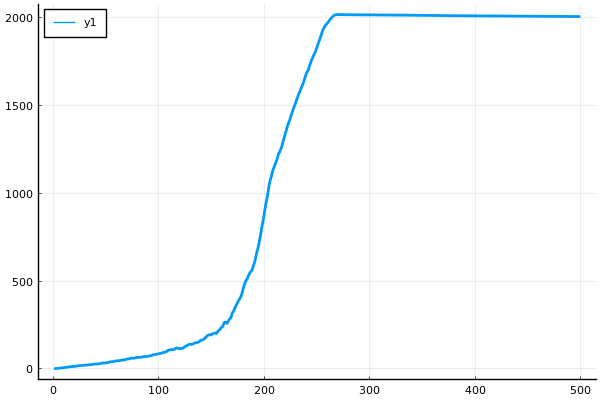

In [93]:
t = 201

plot(mean(data_100[1].z[:,:,t],dims=2),linewidth=2)
#plot!(mean(data_200[1].z[:,:,1000],dims=2),linewidth=2)
#plot!(mean(data_inf[1].z[:,:,t],dims=2),linewidth=2)

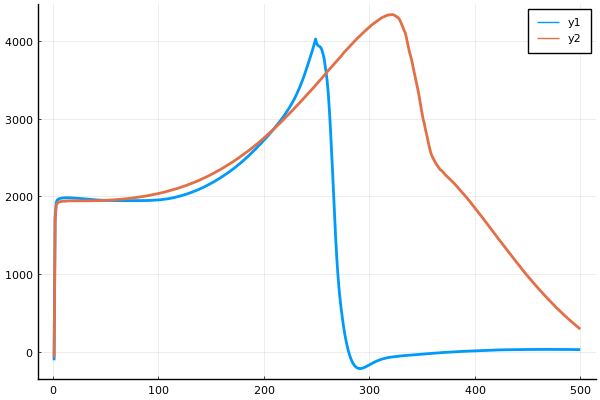

In [67]:
t = 1000
data = data_50_dk
sumu = data_50_dk[1].u[:,:,t]
for i = 2:t
    sumu += data[1].u[:,:,t]
end

plot(mean(data[1].z[:,:,1]-data[1].z[:,:,t]+sumu,dims=2),linewidth=2)

# if false
# sumu = data_200[1].u[:,:,1]
# for i = 2:t
#     sumu += data_50[1].u[:,:,t]
# end

# plot!(mean(data_200[1].z[:,:,1]-data_200[1].z[:,:,t]+sumu,dims=2),linewidth=2)

sumu = data_inf[1].u[:,:,1]
for i = 2:t
    sumu += data_inf[1].u[:,:,t]
end

plot!(mean(data_inf[1].z[:,:,1]-data_inf[1].z[:,:,t]+sumu,dims=2),linewidth=2)
#plot(mean(data_50[1].z[:,:,1]-data_50[1].z[:,:,t]+sumu,dims=2),linewidth=2)


In [79]:
import ipyleaflet 


ArgumentError: [91mArgumentError: Package ipyleaflet not found in current path:[39m
[91m- Run `import Pkg; Pkg.add("ipyleaflet")` to install the ipyleaflet package.[39m


In [55]:
data = data_10

heatmap(data[1].z[:,:,t]- data[1].z[:,:,t-1]+data[1].z[:,:,t]-data[1].z[:,:,t-1],clim=(-10, 0))

UndefVarError: [91mUndefVarError: data_10 not defined[39m

In [ ]:
## Te 10 km 

lemur_params.flex = 10e3
lemur_params.t_c = 10000000000000000e6
data_inf = run_lemur.run(lemur_params)

In [ ]:
## Te 10 km 
lemur_params.flex = 10e3
lemur_params.t_c = 50e6
data_10 = run_lemur.run(lemur_params)

In [ ]:
lemur_params.t_c = 100000000000000000000000000000000000000e6
lemur_params.t = 10e6
lemur_params.dt = .1e6
data_100 = run_lemur.run(lemur_params)

In [ ]:
lemur_params.t_c = 200e6
lemur_params.t = 200e6 
lemur_params.dt = .2e6
data_200 = run_lemur.run(lemur_params)

In [ ]:
lemur_params.t_c = 200e6
data_1000 = run_lemur.run(lemur_params)

In [ ]:
## Te 10 km 

lemur_params.flex = 10e3
lemur_params.t_c = 10e6
data_10 = run_lemur.run(lemur_params)